In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
import pandas as pd

#Read CSV to pandas dataframe, header first row 
df=pd.read_csv('5BatchSite.csv', header = 0, low_memory=False)

# Create your model
model = LinearRegression()

In [2]:
#Check column data types
df.dtypes

YEAR          int64
DateTime     object
MONTH         int64
DAY           int64
DOY           int64
             ...   
uStar       float64
U5          float64
U50         float64
U95         float64
Site         object
Length: 89, dtype: object

In [3]:
#Define columns to be dropped from dataframe
drop_cols = ['DateTime','TIMESTAMP', 'TIMESTAMP_START','TIMESTAMP_END','Ulevel',"aggregationMode",'season']

In [13]:
#Drop desired columns and visualize
df.drop(drop_cols,axis=1,inplace=True)
df.head()

,YEAR,MONTH,DAY,DOY,HOUR,MINUTE,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_4_1,...,DOYSin,FC,NEE,VPD,Rg,uStar,U5,U50,U95,Site
0,2017,1,1,1,0,15,44.113,43.392,38.394,34.874,...,0.000000,NaN,NaN,49.72756,1150.88,0.131411,0.07006,0.098606,0.137611,PR-xGU
1,2017,1,1,1,0,45,44.113,43.392,38.394,34.874,...,0.000000,NaN,NaN,49.72756,1150.88,0.131411,0.07006,0.098606,0.137611,PR-xGU
2,2017,1,1,1,1,15,44.113,43.392,38.394,34.874,...,0.841471,NaN,NaN,49.72756,1150.88,0.131411,0.07006,0.098606,0.137611,PR-xGU
3,2017,1,1,1,1,45,44.113,43.392,38.394,34.874,...,0.841471,NaN,NaN,49.72756,1150.88,0.131411,0.07006,0.098606,0.137611,PR-xGU
4,2017,1,1,1,2,15,44.113,43.392,38.394,34.874,...,0.909297,NaN,NaN,49.72756,1150.88,0.131411,0.07006,0.098606,0.137611,PR-xGU


In [14]:
#Drop NaN values (mostly in FC)
df = df.dropna()

#Use pd 'category type' to make a list of integers for each site name
groups = df['Site'].astype('category')

In [15]:
#Produces an array of integers unique to site, in this case 0, 1, 2, 3, 4
groups = groups.cat.codes

In [16]:
#Remove site name from dataframe
df.drop(['Site'],axis=1,inplace=True)

In [17]:
#Define x and y
x = df_na.drop(['FC','NEE'], axis = 1)
y = df_na['FC']

In [21]:
#Testing LeaveOneGroupOut crossvalidator
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

logo = LeaveOneGroupOut()

#logo.split splits both x and y into folds by site from our "groups" array
for i, (train_index, test_index) in enumerate(logo.split(x, y, groups)):
    model = LinearRegression().fit(x.iloc[train_index],y.iloc[train_index])
    y_pred = model.predict(x.iloc[test_index])
    score = r2_score(y_pred,y.iloc[test_index])
    print(f'Fold {i}:  R2 Score: {score}')

#All R2 scores the same, this seems wrong

Fold 0:  R2 Score: 0.27927712561845364
Fold 1:  R2 Score: 0.27927712561845364
Fold 2:  R2 Score: 0.27927712561845364
Fold 3:  R2 Score: 0.27927712561845364
Fold 4:  R2 Score: 0.27927712561845364


In [25]:
#Test out data with simple deep learning model
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split

#Define custom data class for data loader
class FluxData(Dataset):

    def __init__(self,x,y):
        #define shape, x_data, and y_data from input x and y torch tensors
        self.n_samples = x.shape[0]
        self.n_features = x.shape[1]

        self.x_data = x # size [n_samples, n_features]
        self.y_data = y # size [n_samples, 1]
       
        

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
#Convert x and y to tensors
Y = torch.Tensor(y.values).reshape(-1,1)
X = torch.Tensor(x.values)


#Split data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size= 0.25)

#Scale data
x_scaler = sklearn.preprocessing.StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)


X_train =torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))


#Define Dataset and loader
train_data = FluxData(X_train,Y_train)
train_loader = DataLoader(dataset=train_data,
                          batch_size=100,
                          shuffle=True,
                          num_workers=0 #Can change if using gpu for parallel computing)

                          
#Define simple feed forward model
class Linear(nn.Module):
    def __init__(self, n_features):
        super(Linear,self).__init__()
        #Define the Layers
        self.network=nn.Sequential(
        nn.Linear(n_features,40),
        nn.ReLU(),
        nn.Linear(40,20),
        nn.ReLU(),
        nn.Linear(20,10),
        nn.ReLU(),
        nn.Linear(10,1)
       
        )
        
    def forward(self,x):
        y=self.network(x)
        return y


#model, loss, and optimizer
model = Linear(X.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr =0.0003, weight_decay = 0.001)

#empty loss arrays to visualize training and test loss
train_loss = []
test_loss = []

#Training Loop (Very, Very slow, so only do 100 epochs until using HPC)
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for i,(inputs, labels) in enumerate(train_loader):
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0 or epoch == num_epochs-1:
            if (i+1) % 500 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}| Loss = {loss.item():.3f}')
    if epoch % 5 == 0:
        model.eval()
        y_pred = model(X_train)
        train_loss.append(loss_fn(y_pred,Y_train))
        y_pred = model(X_test)
        test_loss.append(loss_fn(y_pred,Y_test))


Epoch: 1/100, Step 500| Loss = 0.529
Epoch: 1/100, Step 1000| Loss = 0.179
Epoch: 100/100, Step 500| Loss = 0.135
Epoch: 100/100, Step 1000| Loss = 0.082


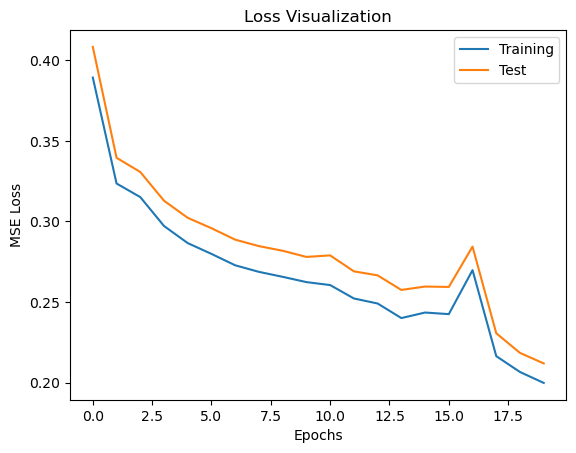

In [28]:
#Visualize training vs test loss
import matplotlib.pyplot as plt
with torch.no_grad():
    fig, ax = plt.subplots()

    ax.plot(train_loss, label="Training")
    ax.plot(test_loss, label="Test")
    ax.legend(loc=0); # upper left corner
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.set_title('Loss Visualization')
    #plt.plot(train_loss, label = 'Training')
    #plt.plot(test_loss, label = 'Test')

In [29]:
#From our loss visualization, we should probably reduce the learning rate

#Calculate R2 metric for both training and test
with torch.no_grad():
    print(f'train r2: {sklearn.metrics.r2_score(model(X_train), Y_train)} ')
    print(f'test r2: {sklearn.metrics.r2_score(model(X_test), Y_test)}')

train r2: 0.7739786324714215 
test r2: 0.768332810368201


In [35]:
#Test run of deep learning model using logo cross validation

#Large learning rate and small num_epochs until on monsoon

#increased num_epochs should drastically increase accuracy. 

for fold, (train_index, test_index) in enumerate(logo.split(X, Y, groups)):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    
    model = Linear(X.shape[1])
  

    loss_fn = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(),lr =0.001, weight_decay = 0)

    train_data = FluxData(X_train,y_train)
    
    train_loader = DataLoader(dataset=train_data,
                              batch_size=100,
                              shuffle=True,
                              num_workers=0)
    model.train()
    num_epochs = 20
    for epoch in range(num_epochs):
        for i,(inputs, labels) in enumerate(train_loader):
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        
        # Make predictions
        outputs = model(X_test)
        outputs_train=model(X_train)
        
        
        # Calculate accuracy for this fold
        score =  r2_score(outputs, y_test)
        score2 = r2_score(outputs_train,y_train)
        
        print(f"Fold {fold+1} R2_test: {score} R2_train: {score2}")
        

    

Fold 1 R2_test: 0.46662701187267874 R2_train: 0.4666270059808977
Fold 2 R2_test: 0.5472424703476075 R2_train: 0.5472424703476076
Fold 3 R2_test: 0.53938220319362 R2_train: 0.53938220319362
Fold 4 R2_test: 0.5179706728253903 R2_train: 0.5179706739662566
Fold 5 R2_test: 0.5324734196138636 R2_train: 0.5324734196138636


In [36]:
#Start looking at step-wise regression
import numpy as np
import statsmodels.api as sm

def get_stats(x,y):
    x = x
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats(x,y)

                                 OLS Regression Results                                
Dep. Variable:                     FC   R-squared (uncentered):                   0.582
Model:                            OLS   Adj. R-squared (uncentered):              0.581
Method:                 Least Squares   F-statistic:                              3270.
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        12:30:50   Log-Likelihood:                     -1.8644e+05
No. Observations:              181215   AIC:                                  3.730e+05
Df Residuals:                  181138   BIC:                                  3.738e+05
Df Model:                          77                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------